In [1]:
import torch
from detectron2.data.datasets import register_coco_instances
from detectron2.utils.visualizer import Visualizer
from detectron2.engine import DefaultTrainer
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2 import model_zoo
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import warnings
# These warnings are not impactful on the output
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", message=".*incompatible shapes.*")

In [2]:
# # this block is used when changing the registered dataset
#
# from detectron2.data import MetadataCatalog
# # remove metadata of dataset from registry
# MetadataCatalog.remove("barnacle_train")

In [3]:
# Register dataset
register_coco_instances(
    "barnacle_train",
    {},
    "barnacle_dataset/annotations/train.json",  # COCO-style annotations (see below)
    "barnacle_dataset/train/images"  # Path to image directory
)

In [5]:
# Define configuration
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("barnacle_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Pre-trained weights
cfg.SOLVER.IMS_PER_BATCH = 1
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 2000    # Keep training short for small dataset
cfg.SOLVER.AMP.ENABLED = True  # Enable automatic mixed precision
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # Only barnacle class

# free up gpu memory
torch.cuda.empty_cache()

In [6]:
# Start training
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[01/29 01:09:10 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (1, 256, 1, 1) in

[01/29 01:09:12 d2.engine.train_loop]: Starting training from iteration 0


C:\Users\Aryan Bawa\PyCharmMiscProject\.venv\Lib\site-packages\torch\functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3596.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
C:\Users\Aryan Bawa\PyCharmMiscProject\.venv\Lib\site-packages\torch\optim\lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


[01/29 01:09:47 d2.utils.events]:  eta: 0:25:19  iter: 19  total_loss: 5.916  loss_cls: 0.7163  loss_box_reg: 0.1938  loss_mask: 0.691  loss_rpn_cls: 3.866  loss_rpn_loc: 0.4605    time: 1.6359  last_time: 4.7041  data_time: 0.1548  last_data_time: 0.0039   lr: 4.9953e-06  max_mem: 7366M
[01/29 01:10:13 d2.utils.events]:  eta: 0:29:45  iter: 39  total_loss: 3.111  loss_cls: 0.6868  loss_box_reg: 0.2857  loss_mask: 0.6859  loss_rpn_cls: 1.028  loss_rpn_loc: 0.4451    time: 1.4664  last_time: 0.9469  data_time: 0.0030  last_data_time: 0.0032   lr: 9.9902e-06  max_mem: 7366M
[01/29 01:10:39 d2.utils.events]:  eta: 0:31:38  iter: 59  total_loss: 2.515  loss_cls: 0.655  loss_box_reg: 0.2692  loss_mask: 0.6781  loss_rpn_cls: 0.4895  loss_rpn_loc: 0.4625    time: 1.4000  last_time: 2.1464  data_time: 0.0038  last_data_time: 0.0061   lr: 1.4985e-05  max_mem: 7366M
[01/29 01:11:04 d2.utils.events]:  eta: 0:32:46  iter: 79  total_loss: 2.351  loss_cls: 0.613  loss_box_reg: 0.2926  loss_mask: 0.6

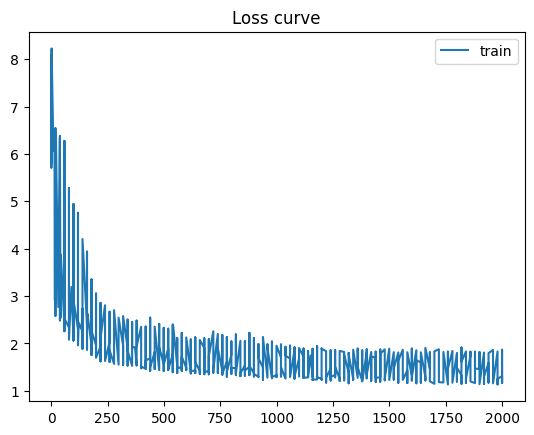

In [7]:
# plot the training loss
metrics_df = pd.read_json("./output/metrics.json", orient="records", lines=True)
mdf = metrics_df.sort_values("iteration")
mdf.head(10).T
fig, ax = plt.subplots()
mdf1 = mdf[~mdf["total_loss"].isna()]
ax.plot(mdf1["iteration"], mdf1["total_loss"], c="C0", label="train")
# ax.set_ylim([0, 3])
ax.legend()
ax.set_title("Loss curve")

#Save the plot as an image file
plt.savefig("loss_curve.png")

plt.show()

In [16]:
# Load trained model
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.WEIGHTS = "output/model_final.pth"
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # Only barnacle class
cfg.TEST.DETECTIONS_PER_IMAGE = 5000
cfg.MODEL.RPN.PRE_NMS_TOPK_TEST = 5000
cfg.MODEL.RPN.POST_NMS_TOPK_TEST = 5000
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.75  # Set the testing threshold for this model
cfg.INPUT.MIN_SIZE_TEST = 250 # min size yields best predictions with 0 for zoomed out images and 250 for zoomed in images
cfg.INPUT.MAX_SIZE_TEST = 9999
predictor = DefaultPredictor(cfg)

# Predict on a new ROI
roi = cv2.imread("barnacle_dataset/test/roi_unseen_img2.png")
if roi is None:
    raise FileNotFoundError("The test image was not found or could not be read.")

# Resize the image
new_width = 1800  # Set the desired width
new_height = 1800  # Set the desired height
roi = cv2.resize(roi, (new_width, new_height))

outputs = predictor(roi)

# Visualize results
v = Visualizer(roi[:, :, ::-1], scale=0.5)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

# Save the output image
output_image = out.get_image()[:, :, ::-1]
# cv2.imwrite("output/images/result.png", output_image)

# Optionally, display the image
cv2.imshow("Result", output_image)
cv2.waitKey(0)
cv2.destroyAllWindows()

# count barnacles
num_barnacles = len(outputs["instances"])
print(f"Number of barnacles detected: {num_barnacles}")

[01/29 02:01:34 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from output/model_final.pth ...
Number of barnacles detected: 148
